In [1]:
from ultralytics import YOLOWorld
from ultralytics import SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import torchvision
import numpy as np
import scipy.sparse as sp
import torch
import os
import matplotlib.pyplot as plt
import cv2
import sys

In [2]:

# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None, save_path=None):
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_result = sorted(result_dict, key=(lambda x: x['area']), reverse=True)
    # Plot for each segment area
    for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))
    plt.savefig(save_path)  

def SegmentAnything(image_path, directory):
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"

    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)
    mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=40)

    # Read the image from the path
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate segmentation mask
    output_mask = mask_generator.generate(image)
    # print(output_mask)

    _,axes = plt.subplots(1,2, figsize=(16,16))
    axes[0].imshow(image)
    image_path = os.path.join(directory, "sam_result.jpg")
    show_output(output_mask, axes[1], image_path)

    masks = mask_generator.generate(image)
    # store the masks in the directory
    output_dir = os.path.join(directory, "./masks/")
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for i in range(len(masks)): 
        sp.save_npz(os.path.join(output_dir, (str(i)+".npz")), sp.csr_matrix(masks[i]['segmentation'] ))

    return masks


In [5]:
os.getcwd()

'/home/ty/Documents/BoulderBrain/backend/services'

In [6]:
cd ..

/home/ty/Documents/BoulderBrain/backend


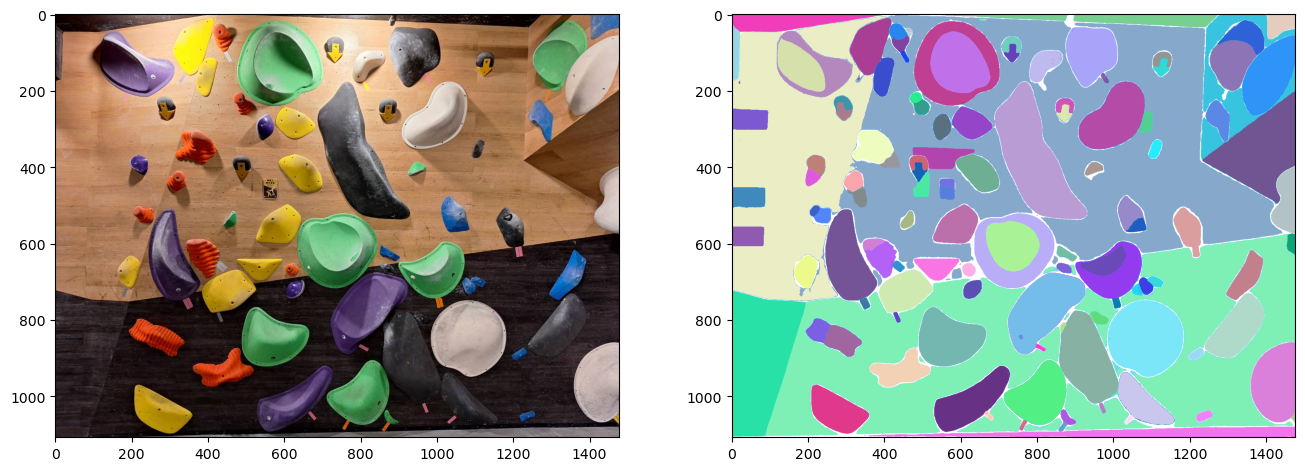

In [7]:
image_path = 'services/files/860.jpg'
directory = 'services/result4'
masks = SegmentAnything(image_path, directory)

In [10]:
holds = []
def getHolds_manually(image_path, masks, directory, click_points, count, wid):
    # holds = []
    # find the bounding box of the mask corresponding to the bboxes
    image = cv2.imread(image_path)
    # print(f"Total {len(click_points)} items clicked in the image.")
    
    for point in click_points:
        hold_mask = np.zeros((image.shape[0], image.shape[1]))
        for j in range(len(masks)):
            # check if point is in masks[j]['segmentation']
            hold_mask = np.zeros((image.shape[0], image.shape[1]))
            hold_mask = np.where(masks[j]['segmentation'], 1, hold_mask)
            if(hold_mask[point[1], point[0]] == 1):
                image = np.where(masks[j]['segmentation'][:,:,None], [0,0,255], image)
                holds.append(hold_mask)
                count = count + 1
                break
            
    # print(f"Total {count} items detected in the image.")
    # plt.imshow(image)
    path = os.path.join(directory, f"{wid}_holds.jpg")
    cv2.imwrite(path, image)

    return holds, count

In [18]:
click_points = [(432, 59), (869, 668)]
getHolds_manually(image_path, masks, directory, click_points, 0, 4)

([array([[          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         ...,
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0]]),
  array([[          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         ...,
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,        